# Import Packages

In [1]:
from packages import *

# Read Dataset

In [2]:
names_df = pd.read_csv('name_gender.csv')
names_df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


# Preprocess Data

In [3]:
def preprocess(names_df):
    # Step 1: Lowercase
    names_df['name'] = names_df['name'].str.lower()
    
    # Remove accent
    names_df['name'] = names_df['name'].apply(lambda x:unidecode.unidecode(x))
    
    # Remove non-alphabet characters
    names_df['name'] = [
        "".join([
            char
            for char in name
            if char.isalpha()==True
        ])
        for name in names_df['name']
    ]
    
    # drop duplicate rows
    names_df = names_df.drop_duplicates().reset_index(drop=True)
    
    # drop NaN
    names_df = names_df.dropna().reset_index(drop=True)
    
    
    # Step 5: Encode Gender to Numbers
    names_df['gender'] = [
        0 if gender=='F' else 1
        for gender in names_df['gender']
    ]
    
    return names_df

In [4]:
names_df = preprocess(names_df)
names_df.head()

,name,gender
0,aaban,1
1,aabha,0
2,aabid,1
3,aabriella,0
4,aada,0


# Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(names_df['name'],
                                                    names_df['gender'],
                                                    test_size=0.2,
                                                    stratify = names_df['gender'])

In [6]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((76020,), (76020,), (19005,), (19005,))

In [7]:
print('Training Class Distribution:',Counter(y_train))
print('Testing Class Distribution:',Counter(y_test))

Training Class Distribution: Counter({0: 48243, 1: 27777})
Testing Class Distribution: Counter({0: 12061, 1: 6944})


# Feature Extraction

In [8]:
# Extract character-level Tfidf features
cv = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char')

In [9]:
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

In [10]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((76020, 26), (76020,), (19005, 26), (19005,))

# Handle Class Imbalance

In [11]:
# SMOTE for Oversampling
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [12]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((96486, 26), (96486,), (19005, 26), (19005,))

In [13]:
print('Training Class Distribution:',Counter(y_train))
print('Testing Class Distribution:',Counter(y_test))

Training Class Distribution: Counter({1: 48243, 0: 48243})
Testing Class Distribution: Counter({0: 12061, 1: 6944})


# Define Functions

In [14]:
def scores(clf):
    print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
    print("Test set score: {:.3f}".format(clf.score(X_test, y_test)))

In [15]:
def test_report(clf):
    y_pred = clf.predict(X_test)
    labels = ['Female','Male']
    
    array = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(array, index = labels, columns = labels)
    
    plt.title("Confusion Matrix")
    s = sns.heatmap(df_cm, annot=True, cmap='copper', fmt='g')
    s.set(xlabel='Predicted Label', ylabel='True Label')
    print('*'*100)
    
    print(classification_report(y_test, y_pred, target_names = labels))

In [16]:
def roc(clf):
    disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title('ROC Curve')
    plt.plot([0,1],[0,1],'k--')
    plt.show()

In [17]:
params = {}
models = {}

def call(name,model,space):
    
    clf = GridSearchCV(estimator = model, 
                      param_grid = space,
                      cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42),
                       scoring = 'f1',
                      verbose= 0,
                      n_jobs = -1)
    
    clf.fit(X_train, y_train)
    print('Best training parameters:',clf.best_params_)
     
    best_estimator = clf.best_estimator_
    
    scores(best_estimator)
    print('*'*100)
    
    test_report(best_estimator)
    print('*'*100)
    
    roc(best_estimator)
    
    params[name] = clf.best_params_
    models[name] = best_estimator

# Naiive Bayes

Best training parameters: {'var_smoothing': 0.2848035868435802}
Training set score: 0.653
Test set score: 0.674
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.74      0.75      0.74     12061
        Male       0.56      0.55      0.55      6944

    accuracy                           0.67     19005
   macro avg       0.65      0.65      0.65     19005
weighted avg       0.67      0.67      0.67     19005

****************************************************************************************************


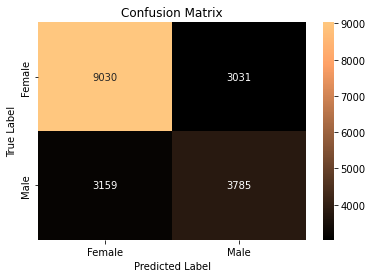

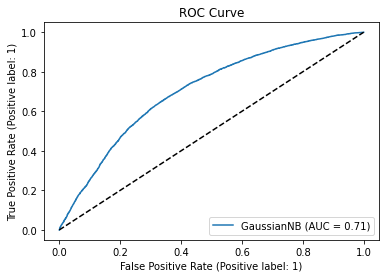

In [18]:
# Domain/Search Space
space = {'var_smoothing': np.logspace(0,-9, num=100)}

# training
model = GaussianNB()
call('NB', model, space)

# Random Forest

Best training parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}
Training set score: 0.871
Test set score: 0.754
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.82      0.78      0.80     12061
        Male       0.65      0.71      0.68      6944

    accuracy                           0.75     19005
   macro avg       0.74      0.74      0.74     19005
weighted avg       0.76      0.75      0.76     19005

****************************************************************************************************


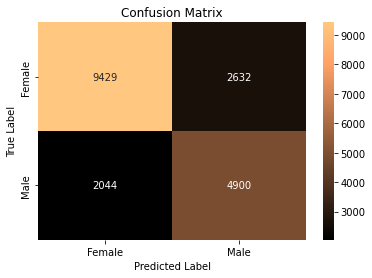

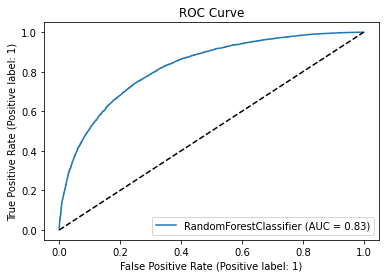

In [19]:
# Domain/Search Space
space = {'bootstrap': [True, False],
         'max_depth': [5, 7, 8, 10, None],
         'min_samples_leaf': [2, 5, 10, 20],
         'min_samples_split': [2, 5, 10, 20],
         'n_estimators': [50, 100, 200, 500]}

# training
model = RandomForestClassifier()
call('RF', model, space)

# Logistic Regression

Best training parameters: {'C': 1, 'penalty': 'l2'}
Training set score: 0.695
Test set score: 0.690
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.80      0.68      0.74     12061
        Male       0.56      0.70      0.62      6944

    accuracy                           0.69     19005
   macro avg       0.68      0.69      0.68     19005
weighted avg       0.71      0.69      0.70     19005

****************************************************************************************************


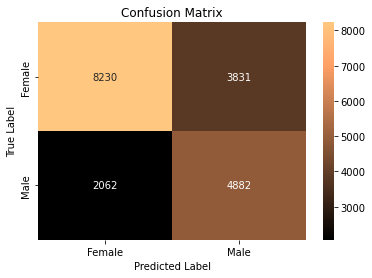

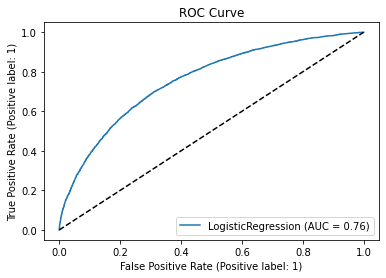

In [21]:
# Domain/Search Space
space = {'penalty' : ['l1', 'l2','elasticnet','none'], 
                 'C' : [0.01, 0.1, 1, 10, 100]}

# training
model = LogisticRegression()
call('LR', model, space)

# K-NN

Best training parameters: {'n_neighbors': 3}
Training set score: 0.874
Test set score: 0.720
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.80      0.75      0.77     12061
        Male       0.61      0.67      0.64      6944

    accuracy                           0.72     19005
   macro avg       0.70      0.71      0.70     19005
weighted avg       0.73      0.72      0.72     19005

****************************************************************************************************


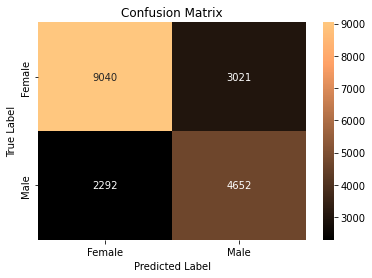

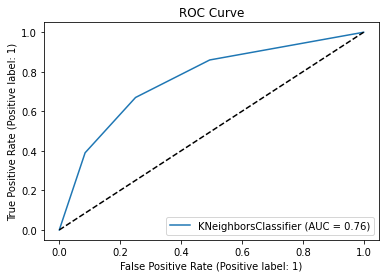

In [22]:
# Domain/Search Space
space = {'n_neighbors' : list(range(3,20,2))}

# training
model = KNeighborsClassifier()
call('KNN', model, space)

# SVM

Best training parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training set score: 0.793
Test set score: 0.762
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.83      0.79      0.81     12061
        Male       0.66      0.72      0.69      6944

    accuracy                           0.76     19005
   macro avg       0.74      0.75      0.75     19005
weighted avg       0.77      0.76      0.76     19005

****************************************************************************************************


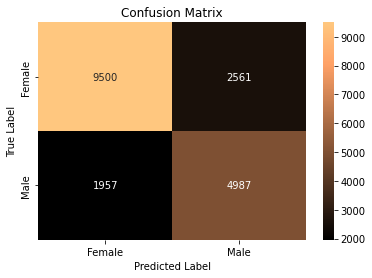

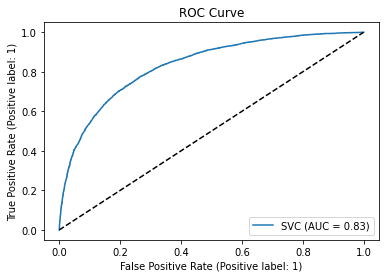

In [23]:
# Domain/Search Space
space = {'C': [0.01, 0.1, 1, 10, 100], 
 'gamma': [1, 0.1, 0.01, 0.001],
 'kernel': ['linear','rbf', 'poly', 'sigmoid']}

# training
model = SVC()
call('SVM', model, space)

# Save models

In [27]:
path = 'models/'

In [28]:
# save models
for i in models:
    filename = i+'.sav'
    clf = models[i]
    pickle.dump(clf, open(path+filename, 'wb'))